<a href="https://colab.research.google.com/github/JoelByron/AI_Camp_TalentoTech/blob/main/notebooks/10_Modelo_prediccion_de_series_temporales_Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalar el paquete Chronos desde un repositorio de GitHub

pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-6yzeepf7
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-6yzeepf7
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit ac6ee36acee1e47446cd66f72f540c87f1f1fbe4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for chronos: filename=chronos-1.2.1-py3-none-any.whl size=13927 sha256=15b25282dc2f2af5a65a568da085336ae2abf86c736318cc5dc645ff5802ac65
  Stored in directory: /tmp/pip-ephem-wheel-cache-yybjfjb6/wheels/bf/c1/65/08857e57345ef1b34ba0edb4791f1b2594943e82f34e93a4ab
Successfully built chronos


In [7]:
# Importa Librerias
import pandas as pd
import matplotlib.pyplot as plt
import torch
from chronos import ChronosPipeline
import warnings
warnings.filterwarnings('ignore')

#
df =  pd.read_csv("http://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [8]:
df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


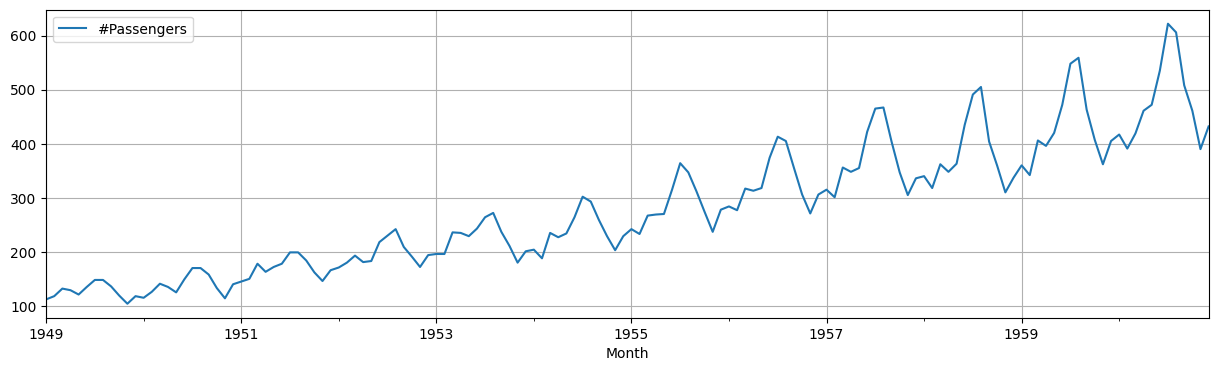

In [9]:
# Convierte la columna Month en tipo DateTime y la establece como indice

df["Month"] = pd.to_datetime(df["Month"])
df = df.set_index("Month").sort_index()
df.plot(figsize=(15,4), grid= True);

In [10]:
# Divide el conjunto de datos sobre el numero de pasajeros mensuales menores a 1960
# Divide el conjunto de datos en dos datos de entrenamiento (df_train) antes de 1960 y datos de prueba (df_test) desde 1960 en adelante.

df_train = df.loc[df.index < '1960-01-01'].copy()
df_test = df.loc[df.index >= '1960-01-01'].copy()
print ("datos de entrenamiento;", len(df_train), "Datos de evaluación;", len(df_test))

datos de entrenamiento; 132 Datos de evaluación; 12


In [13]:
# Crea una instancia del modelo Chronos preentrenado (chronos-t5-small) y lo asigna para ejecutarse en el CPU con tipo de datos bfloat16,
# optimizado para cargas de trabajo de PyTorch
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
  device_map="cpu",
    torch_dtype=torch.bfloat16,
)
# Utiliza el df_train para predecir el numero de pasajeros en los proximps 12 meses
# la predicción se hace con 20 muestras para capturar incertidumbre y generar multiples valores predichos para cada punto en el tiempo futuro
forecast = pipeline.predict(
    context=torch.tensor(df_train["#Passengers"]),
    prediction_length = 12,
    num_samples= 20,
)

In [14]:
forecast.shape

torch.Size([1, 20, 12])

In [15]:
forecast

tensor([[[419.5260, 407.9795, 475.3346, 448.3925, 465.7124, 550.3873, 629.2891,
          635.0624, 542.6896, 469.5612, 406.0550, 458.0146],
         [411.8283, 407.9795, 463.7879, 459.9391, 477.2590, 575.4050, 662.0044,
          662.0044, 561.9340, 494.5789, 419.5260, 486.8811],
         [409.9039, 390.6595, 446.4681, 427.2238, 454.1658, 529.2186, 611.9691,
          638.9112, 569.6317, 498.4277, 440.6948, 490.7300],
         [398.3573, 379.1130, 431.0726, 419.5260, 442.6192, 488.8056, 565.7828,
          585.0271, 513.8232, 440.6948, 392.5840, 438.7703],
         [402.2061, 384.8863, 452.2414, 452.2414, 473.4101, 550.3873, 611.9691,
          617.7424, 525.3698, 452.2414, 413.7527, 465.7124],
         [402.2061, 392.5840, 463.7879, 450.3169, 458.0146, 538.8408, 596.5737,
          611.9691, 513.8232, 440.6948, 402.2061, 456.0902],
         [400.2817, 379.1130, 431.0726, 421.4505, 444.5436, 515.7476, 577.3294,
          608.1203, 494.5789, 448.3925, 392.5840, 434.9215],
         [417

In [16]:
# Promedia las 20 muestras generadas para cada mes, obteniendo un valor promedio para cada predicción

forecast_values = [float((forecast[0,:,x].mean())) for x in range(forecast.shape[2])]
forecast_values

[411.92449951171875,
 395.85552978515625,
 449.16229248046875,
 436.5572204589844,
 456.9562072753906,
 526.8131103515625,
 604.7525634765625,
 616.4915771484375,
 521.7133178710938,
 455.70538330078125,
 406.72857666015625,
 458.4957580566406]

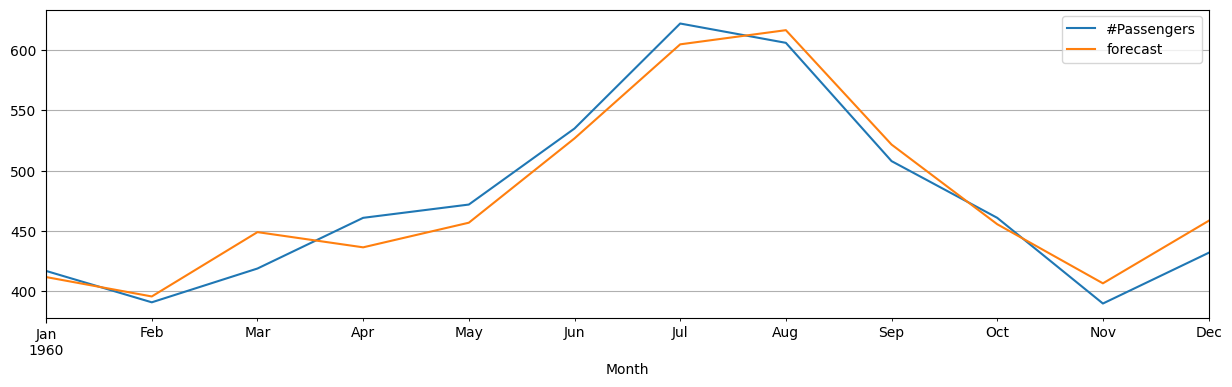

In [17]:
df_test["forecast"] = forecast_values
df_test.plot(figsize=(15,4), grid= True);

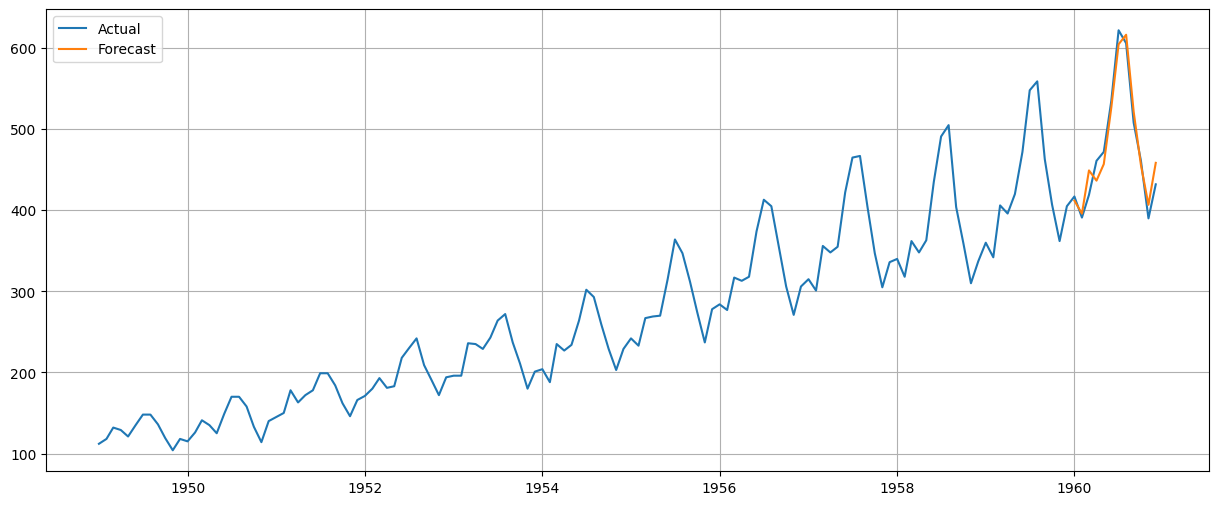

In [18]:
# Gráfica  los valores originales y las predicciones para visualizar el ajuste del modelo
plt.figure(figsize=(15, 6))
plt.plot(df["#Passengers"], label='Actual')
plt.plot(df_test["forecast"], label='Forecast')
plt.legend()
plt.grid()
plt.show()
